In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This notebook contains code to reproduce the following from Mitra, et al.:

**Main Figures:** 
* Figure 1B: Number of mutations per person 
* Figure 1C: Correlation of # mutations with paternal age 

**Statistics:**
* Number of total families included after filtering
* Total number of mutations passing filters (autosomes) (chrX in fig 3 notebook)
* Total number of distinct loci with mutations (autosomes/chrX)
* Number of mutations per healthy child (autosome/chrX)
* Correlation of mutation counts wihin family
* Correlation of # mutations with paternal and maternal age
* Ratio of paternal:maternal mutations

In [8]:
# Input mutation results
MUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.final_qc_mutations.tab"
NAIVEMUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_011720_denovos_naive_Jan20.final_qc_mutations.tab"

MUTFILEX = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/SSC_allphases_072820_denovos_model_X.denovos.final_qc_mutations.tab"
NAIVEMUTFILEX = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_072820_denovos_naive_X.denovos.final_qc_mutations.tab"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats

# Other input data
AGEFILE = "/storage/ileena/denovos4/metadata/ssc_4phases_ages.csv"

# Output path info
OUTDIR = "pdfs/"

In [9]:
# Load main mutations data
alldata = pd.read_csv(MUTFILE, sep="\t")
usefams = set(alldata["family"])

alldata_x = pd.read_csv(MUTFILEX, sep="\t")
alldata_x = alldata_x[alldata_x.family.isin(usefams)]

# Load expansions identified using naive method
ndata = pd.read_csv(NAIVEMUTFILE, sep="\t")
ndata = ndata[(ndata["posterior"]==-1) & (ndata["mutsize"]>=5)] # moderately big expansion events
# Filter ones that occur too many times
expcounts = ndata.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata = pd.merge(ndata, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])

# Load expansions - X
ndata_x = pd.read_csv(NAIVEMUTFILEX, sep="\t")
ndata_x = ndata_x[(ndata_x["posterior"]==-1) & (ndata_x["mutsize"]>=5)] # moderately big expansion events
# Filter ones that occur too many times
expcounts = ndata_x.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata_x = pd.merge(ndata_x, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])

# Concatenate expansions
ndata = ndata[ndata.family.isin(usefams)]
alldata = pd.concat([alldata, ndata]).drop_duplicates()

ndata_x = ndata_x[ndata_x.family.isin(usefams)]
alldata_x = pd.concat([alldata_x, ndata_x]).drop_duplicates()

# Manually remove remaining problematic families.
# 14151 proband had 130 mutations
# other families have <20 in both proband and sibling
rmfams = [14151, 12434, 12281, 13673, 13351, 13355, 13143]

alldata = alldata[~alldata.family.isin(rmfams)]
alldata_x = alldata_x[~alldata_x.family.isin(rmfams)]

ages = pd.read_csv(AGEFILE)
ages["family"] = ages["fam_id"]
ages["child"] = ages["sample_id"]
alldata_x = pd.merge(alldata_x, ages[["child","sex"]], how="left")

In [10]:
# Number of unique families
print("Number of unique families: %s"%len(set(alldata["family"])))

# Total number of mutations
print("Number of total mutations (autosomes): %s"%alldata.shape[0])
# Total number of mutations - autosomes + chrX 
print("Number of total mutations (autosomes+chrX): %s"%(alldata.shape[0]+alldata_x.shape[0]))


# Total number of distinct loci - autosomes 
print("Number of distinct autosomal loci: %s"%(alldata[["chrom","pos"]].drop_duplicates().shape[0]))
# Total number of distinct loci - autosomes + chrX
print("Number of distinct autosomal+chrX loci: %s"%(alldata[["chrom","pos"]].drop_duplicates().shape[0]+
                                               alldata_x[["chrom","pos"]].drop_duplicates().shape[0]))

Number of unique families: 1593
Number of total mutations (autosomes): 171578
Number of total mutations (autosomes+chrX): 174330
Number of distinct autosomal loci: 91925
Number of distinct autosomal loci: 93880


# Figure 1B: Number of mutations per person

Healthy child - median=52.0 mean=53.05398618957941
ASD child - median=54.0 mean=54.653483992467045
Total average = 53.853735091023225


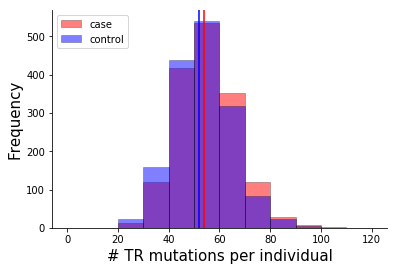

In [11]:
# Get number of mutations per sample
mut_ctrl = alldata[alldata["phenotype"]==1].groupby(["family"], as_index=False).agg({"child": len})
mut_ctrl.columns = ["family","num_ctrl"]
mut_case = alldata[alldata["phenotype"]==2].groupby(["family"], as_index=False).agg({"child": len})
mut_case.columns = ["family","num_case"]
famdata = pd.merge(mut_ctrl, mut_case, on=["family"])

# Plot number of mutations per sample histogram
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(famdata["num_case"], color="red", alpha=0.5, bins=np.arange(0, max(famdata["num_case"])+20, 10), edgecolor="black", linewidth=0.5, label="case");
ax.hist(famdata["num_ctrl"], color="blue", alpha=0.5, bins=np.arange(0, max(famdata["num_case"])+20, 10), edgecolor="black", linewidth=0.5, label="control");
ax.set_xlabel("# TR mutations per individual", size=15);
ax.set_ylabel("Frequency", size=15);
ax.axvline(x=np.median(famdata["num_case"]), color="red", linestyle="solid")
ax.axvline(x=np.median(famdata["num_ctrl"]), color="blue", linestyle="solid")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.legend(loc="upper left")
fig.savefig(os.path.join(OUTDIR, "Figure1_NumDenovos.pdf"))

# Stats
print("Healthy child - median=%s mean=%s"%(np.median(famdata["num_ctrl"]), np.mean(famdata["num_ctrl"])))
print("ASD child - median=%s mean=%s"%(np.median(famdata["num_case"]), np.mean(famdata["num_case"])))
mean_num_muts = np.mean(alldata.groupby("child", as_index=False).agg({"posterior": len})["posterior"])
print("Total average = %s"%(mean_num_muts))

# Figure 1C: Correlation with age of parents

cor(# muts, father age)
(0.18680143250773856, 2.0807365914501254e-26)
cor(# muts, mother age)
(0.1616316293217998, 4.307525856695633e-20)
3186
cor(# muts phased to father, father age)
(0.2205904401652447, 2.0636205882358492e-36)
cor(# muts phased to mother, mother age)
(0.059262631368883205, 0.0008334871450119252)


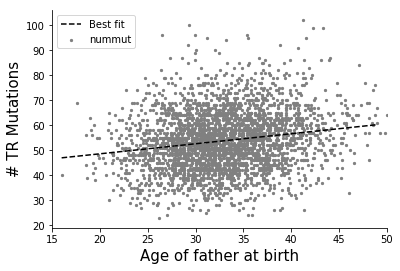

In [12]:
childdata = alldata.groupby(["family","child"], as_index=False).agg({"posterior": len})
childdata.columns = ["family","child","nummut"]
data_ages = pd.merge(childdata, ages[~np.isnan(ages["father_age_birth"])], on=["family","child"])[["family","child", "nummut",
                                                                  "father_age_birth_years","mother_age_birth_years"]]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data_ages["father_age_birth_years"], data_ages["nummut"], color="gray", s=5)
xvals = np.arange(16, 50, 1)
slope, intercept = np.polyfit( data_ages["father_age_birth_years"], data_ages["nummut"], deg=1)
ax.plot(xvals, [intercept+slope*item for item in xvals], color="black", linestyle="dashed", label="Best fit")
ax.set_xlim(left=15, right=50)
ax.set_xlabel("Age of father at birth", size=15)
ax.set_ylabel("# TR Mutations", size=15)
ax.legend(loc="upper left")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
fig.savefig(os.path.join(OUTDIR, "Figure1_PaternalAge.pdf"));

# Print overall correlation with mother/father age
print("cor(# muts, father age)")
print(scipy.stats.pearsonr(data_ages["father_age_birth_years"], data_ages["nummut"]))
print("cor(# muts, mother age)")
print(scipy.stats.pearsonr(data_ages["mother_age_birth_years"], data_ages["nummut"]))
print(data_ages.shape[0])

# Phased mutations correlation with age
childdata_phase = alldata.groupby(["family","child","poocase"], as_index=False).agg({"posterior": len})
childdata_phase.columns = ["family","child","poocase","nummut"]
data_ages_phase = pd.merge(childdata_phase, ages, on=["family","child"])[["family","child", "nummut", "poocase",
                                                                  "father_age_birth_years","mother_age_birth_years"]]
pat_mut = data_ages_phase[data_ages_phase["poocase"]==2]
mat_mut = data_ages_phase[data_ages_phase["poocase"]==3]
print("cor(# muts phased to father, father age)")
print(scipy.stats.pearsonr(pat_mut["father_age_birth_years"], pat_mut["nummut"]))
print("cor(# muts phased to mother, mother age)")
print(scipy.stats.pearsonr(mat_mut["mother_age_birth_years"], mat_mut["nummut"]))

In [13]:
# Parent of origin
usedata = alldata[(alldata["period"]>1)]
counts = list(usedata.groupby(["poocase"], as_index=False).agg({"child": len})["child"]/usedata.shape[0])
print("Paternal percentage: %s"%(counts[0]/(counts[0]+counts[1])))

Paternal percentage: 0.7428651371012871
